# Searching for evidence of mass-dependent heating.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from dispersion import *


from astropy.table import Table
from pyia import GaiaData
import astropy.coordinates as coord

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Download Gaia catalog and apply S/N and astrometric excess noise cuts.

In [2]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "kepler_dr2_1arcsec.fits"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")
    
print(np.shape(gaia))

# Apply S/N cuts.
sn = gaia.parallax.values/gaia.parallax_error.values

m = (sn > 10) * (gaia.parallax.values > 0) * np.isfinite(gaia.parallax.values)

# Remove stars with excess noise.
m &= gaia.astrometric_excess_noise.values < 5

gaia = gaia.iloc[m]
print(np.shape(gaia))

(197090, 101)
(178713, 101)


Get extinction.

In [3]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 19.437 s
  pix_info:   0.471 s
   samples:   8.596 s
      best:   4.036 s
       nan:   0.108 s
      sort:   6.027 s
       idx:   0.199 s


In [4]:
coords = SkyCoord(gaia.ra.values*units.deg, gaia.dec.values*units.deg,
                  distance=(1./(gaia.parallax.values*1e-3))*units.pc)

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.], return_flags=True)

Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)

# Catch places where the extinction uncertainty is zero and default to an uncertainty of .05
m = Av_std == 0
Av_std[m] = .05

In [5]:
gaia["ebv"] = ebv[:, 1]  # The median ebv value.
gaia["Av"] = Av
gaia["Av_errp"] = Av_errp
gaia["Av_errm"] = Av_errm
gaia["Av_std"] = Av_std

Calculate dereddened photometry.

In [6]:
from tools import getDust
    
AG, Abp, Arp = getDust(gaia.phot_g_mean_mag.values, gaia.phot_bp_mean_mag.values,
                       gaia.phot_rp_mean_mag.values, gaia.ebv.values)

In [7]:
gaia["bp_dered"] = gaia.phot_bp_mean_mag.values - Abp
gaia["rp_dered"] = gaia.phot_rp_mean_mag.values - Arp
gaia["bprp_dered"] = gaia["bp_dered"] - gaia["rp_dered"]
gaia["G_dered"] = gaia.phot_g_mean_mag.values - AG

def mM(m, D):
    return 5 - 5*np.log10(D) + m

abs_G = mM(gaia.G_dered.values, 1./(gaia.parallax.values*1e-3))
gaia["abs_G"] = abs_G

Remove nans.

In [8]:
m2 = np.isfinite(gaia.abs_G.values)

gaia_kep = gaia.iloc[m2]

Calculate photometric temperatures.

In [9]:
coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
          -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
          301.13205924630165, -25.923997443169355]
teffs = np.polyval(coeffs[::-1], gaia_kep.bp_dered - gaia_kep.rp_dered)
gaia_kep["color_teffs"] = teffs

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(2000, 10000)

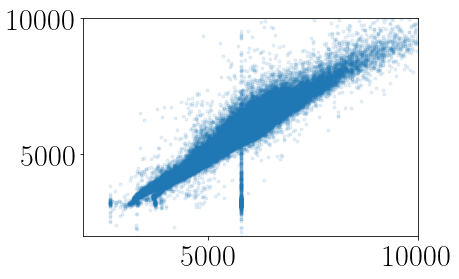

In [10]:
plt.plot(gaia_kep.teff, gaia_kep.color_teffs, ".", alpha=.1)
plt.xlim(2000, 10000)
plt.ylim(2000, 10000)

Plot CMD

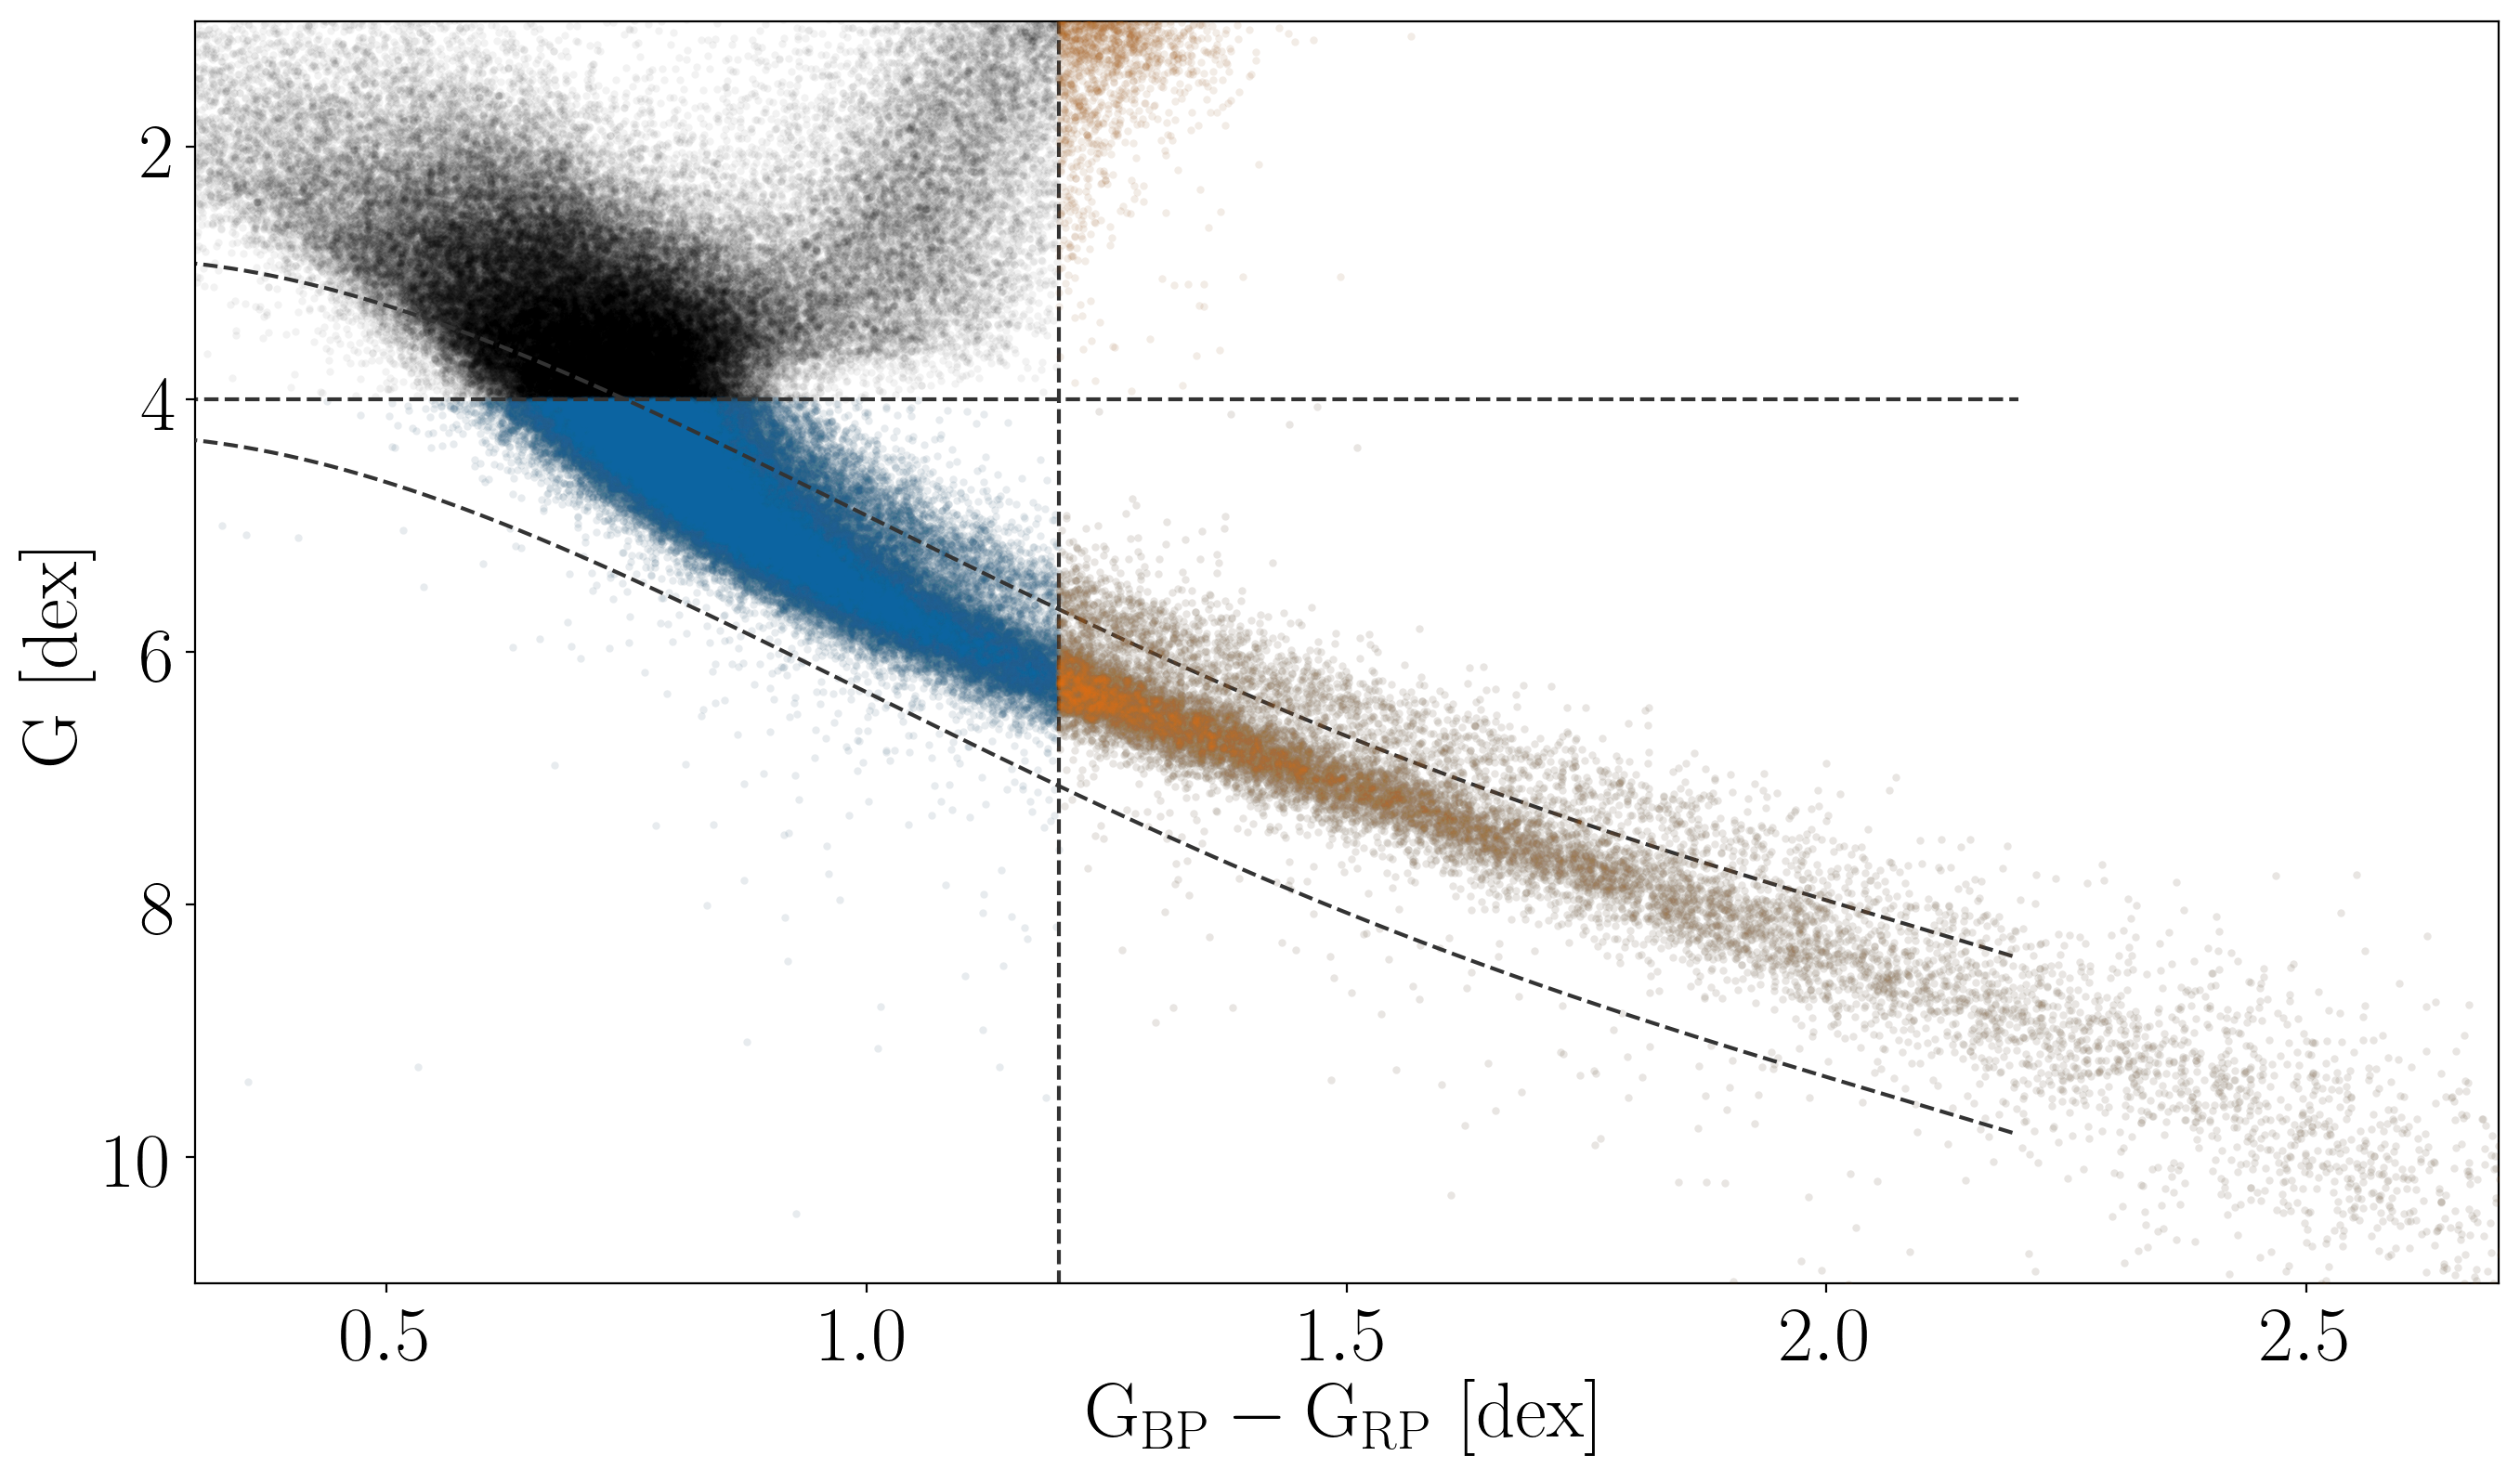

In [11]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gaia_kep.bp_dered - gaia_kep.rp_dered, gaia_kep.abs_G,
         "k.", alpha=.05, mec="none", rasterized=True, zorder=0)
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.ylim(11, 1)
plt.xlim(.3, 2.7);

subcut = 4
colorcut = 1.2
mcolor = (gaia_kep.bp_dered - gaia_kep.rp_dered) > colorcut
m = gaia_kep.abs_G.values > subcut

x = gaia_kep.bp_dered[m] - gaia_kep.rp_dered[m]
y = gaia_kep.abs_G[m]
plt.plot(x, y, ".", alpha=.05, rasterized=True, zorder=1, mec="none")

w = np.polyfit(x, y, 6)

minb, maxb, extra, subdwarf = 0, 2.2, .4, 1  # 2.2
xs = np.linspace(minb, maxb, 1000)
plt.plot(xs, np.polyval(w, xs) - extra, "--", color=".2")
plt.plot(xs, np.polyval(w, xs) + subdwarf, "--", color=".2", zorder=5)
plt.plot(xs, np.ones_like(xs)*subcut, "--", color=".2")
plt.plot(np.ones(100)*colorcut, np.linspace(0, 11, 100), "--", color=".2")

plt.plot(gaia_kep.bp_dered.values[mcolor] - gaia_kep.rp_dered.values[mcolor], gaia_kep.abs_G.values[mcolor],
         "C1.", alpha=.05, rasterized=True, zorder=3, mec="none")

Remove visual binaries, hot stars and subdwarfs.

In [12]:
m = (minb < gaia_kep.bp_dered - gaia_kep.rp_dered) * (gaia_kep.bp_dered - gaia_kep.rp_dered < maxb)
m &= (gaia_kep.abs_G < np.polyval(w, gaia_kep.bp_dered - gaia_kep.rp_dered) - extra) \
    + (subcut > gaia_kep.abs_G)

_m = np.ones(len(m))
_m[m] = np.zeros(sum(m))
_m = _m == 1

# Remove subdwarfs
_m &= (gaia_kep.abs_G < np.polyval(w, gaia_kep.bp_dered - gaia_kep.rp_dered) + subdwarf) \
    | (gaia_kep.bp_dered - gaia_kep.rp_dered > maxb)

flag = np.zeros(len(gaia_kep))
# flag[~m] = np.ones(len(flag[~m])) 
flag[_m] = np.ones(len(flag[_m])) 
gaia_kep["flag"] = flag

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Just look at M dwarfs

In [13]:
# Cut out visual binaries and subgiants
dwarfs = gaia_kep.iloc[gaia_kep.flag.values == 1]
m = dwarfs.bp_dered.values - dwarfs.rp_dered.values > colorcut
mdwarfs = dwarfs.iloc[m]

Text(0, 0.5, '$\\mathrm{G~[dex]}$')

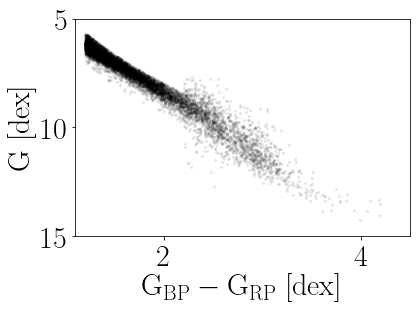

In [14]:
plt.plot(mdwarfs.bp_dered - mdwarfs.rp_dered, mdwarfs.abs_G, "k.", alpha=.1, mec="none")
plt.ylim(15, 5)
plt.xlim(colorcut-.1, 4.5);
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")

Plot bigger CMD.

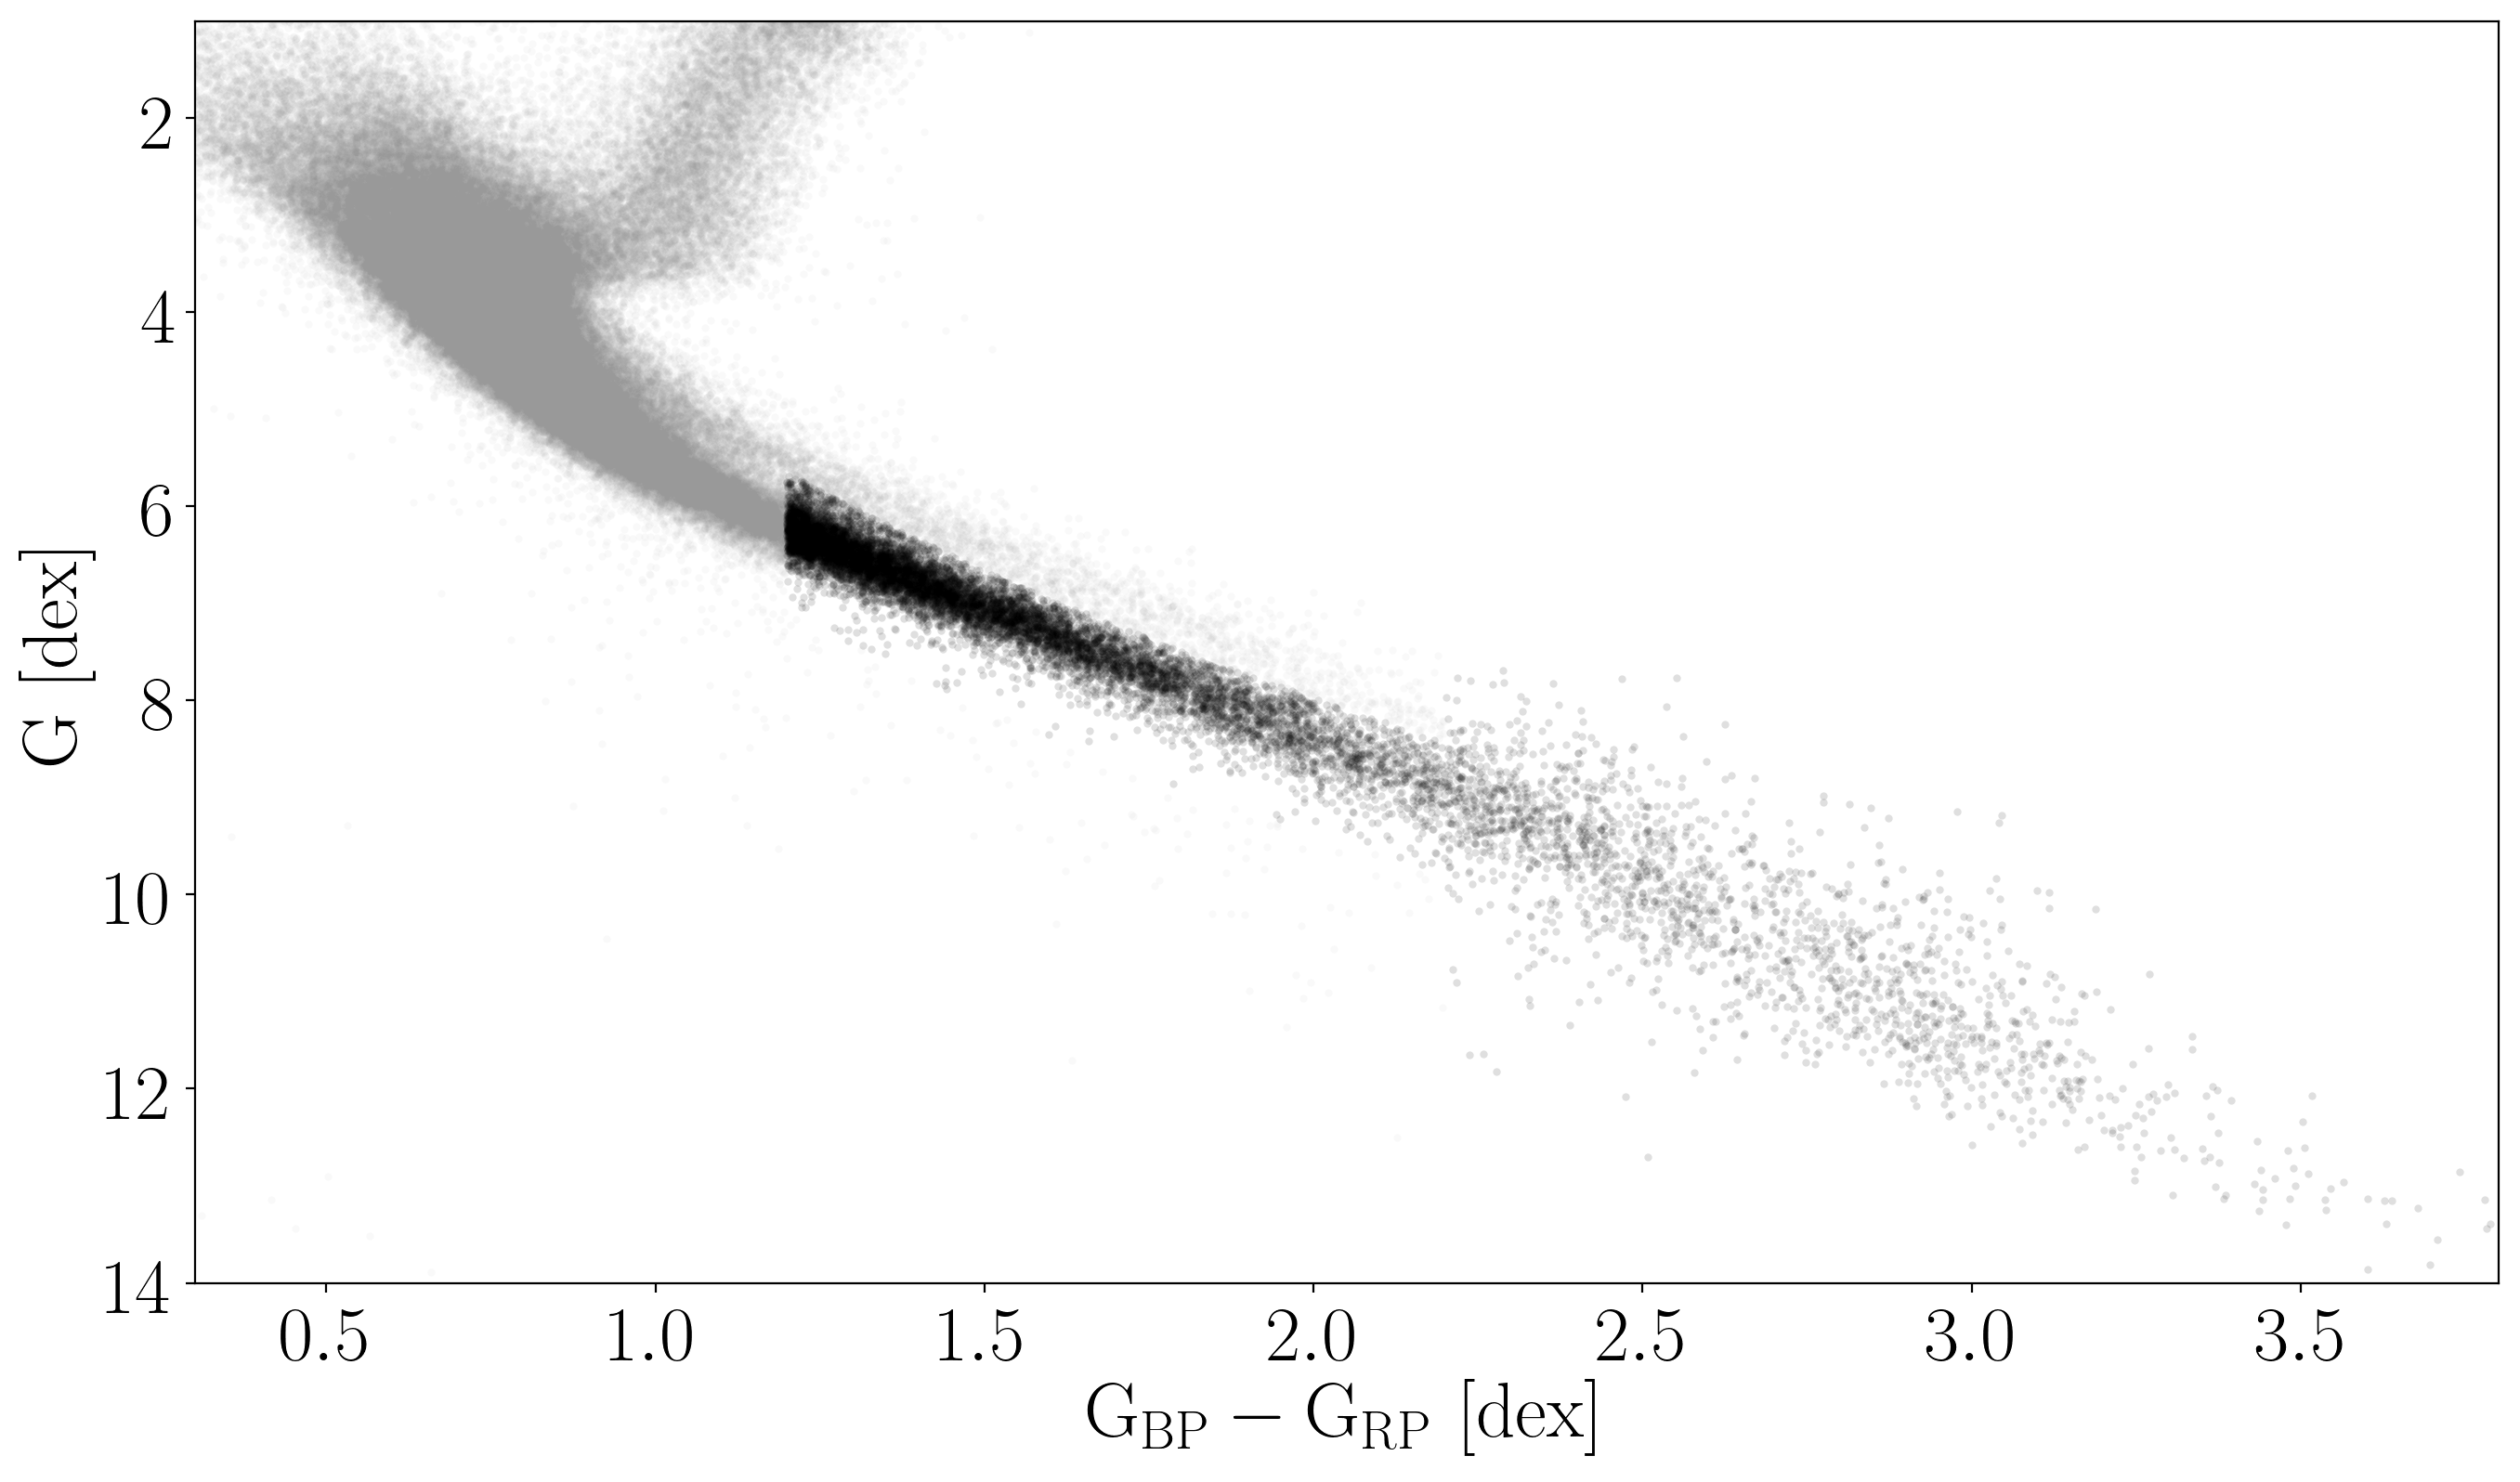

In [15]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gaia_kep.bp_dered - gaia_kep.rp_dered, gaia_kep.abs_G,
         ".", color=".6", alpha=.05, mec="none", rasterized=True, zorder=0)
plt.xlabel("$\mathrm{G_{BP}-G_{RP}~[dex]}$")
plt.ylabel("$\mathrm{G~[dex]}$")
plt.ylim(14, 1)
plt.xlim(.3, 3.8);

plt.plot(mdwarfs.bp_dered - mdwarfs.rp_dered, mdwarfs.abs_G, "k.", alpha=.1, mec="none")

# plt.plot(xs, np.polyval(w, xs) - extra, "--", color="C0")
# plt.plot(xs, np.ones_like(xs)*subcut, "--", color="C0")
# plt.plot(np.ones(100)*colorcut, np.linspace(0, 14, 100), "--", color="C0")
plt.savefig("paper/mdwarf_CMD.pdf")

In [16]:
print(sum(mdwarfs.radial_velocity != 0))

537


Calculate velocities and b

In [17]:
from calc_velocities import calc_vb

pmb_samples, vb_samples = calc_vb(mdwarfs)

In [18]:
pmb, vb = np.median(pmb_samples, axis=1), np.median(vb_samples, axis=1)
pmb_err, vb_err = np.std(pmb_samples, axis=1), np.std(vb_samples, axis=1)
pmb_errp = np.percentile(pmb_samples, 84, axis=1) - pmb
pmb_errm = pmb - np.percentile(pmb_samples, 16, axis=1)
vb_errp = np.percentile(vb_samples, 84, axis=1) - vb
vb_errm = vb - np.percentile(vb_samples, 16, axis=1)

mdwarfs["vb"] = vb
mdwarfs["vb_err"] = vb_err

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Calculate VZ

In [21]:
def calc_vz(pandas_df, nsamples=1000):
    """
    Calculate W samples from a pandas DataFrame.

    Args:
        df (DataFrame): pandas dataframe containing Gaia columns

    Returns:
        W (array): samples of W velocity.
            Shape = nstars x nsamples

    """

    df = Table.from_pandas(pandas_df)
    g = GaiaData(df)
    g_samples = g.get_error_samples(size=nsamples,
                                    rnd=np.random.RandomState(seed=42))
    c_samples = g_samples.get_skycoord()
    vels = c_samples.transform_to(coord.Galactocentric)
    W = vels.v_z.value
    return np.mean(W, axis=1), np.std(W, axis=1)

mrv = mdwarfs.radial_velocity.values != 0.00
vz, vz_err = calc_vz(mdwarfs)
vz[~mrv] = np.ones(len(vz[~mrv]))*np.nan
vz_err[~mrv] = np.ones(len(vz_err[~mrv]))*np.nan
mdwarfs["vz"] = vz
mdwarfs["vz_err"] = vz_err

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Calculate b

[ 9.70970103  9.65040071  9.90117279 ... 17.04289173 16.99095641
 16.92800808]
median =  13.57238522994281
range =  5.623704622139158 21.48183539271286


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


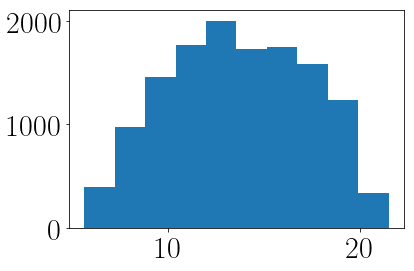

In [22]:
import astropy.units as u
from astropy.coordinates import ICRS
from astropy.coordinates import Galactic

icrs = ICRS(ra=mdwarfs.ra.values*u.degree,
            dec=mdwarfs.dec.values*u.degree)
lb = icrs.transform_to(Galactic)
b = lb.b*u.degree
print(lb.b.value)
plt.hist(b.value);
print("median = ", np.median(b.value))
print("range = ", min(b.value), max(b.value))

mdwarfs["b"] = b.value

Calculate vra and vdec

In [23]:
import astropy.coordinates as coord
import astropy.units as u
d = coord.Distance(parallax=mdwarfs.parallax.values * u.mas)
vra = (mdwarfs.pmra.values*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
vdec = (mdwarfs.pmdec.values*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())

mdwarfs["v_ra"] = vra.value
mdwarfs["v_dec"] = vdec.value

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Calculate vz.

Drop large errorbars and stars at high latitudes.

In [94]:
print(np.shape(mdwarfs))
m = mdwarfs.vb_err.values < 1
m &= mdwarfs.b.values < 15
mdwarfs2 = mdwarfs.iloc[m]
print(np.shape(mdwarfs2))

(13213, 120)
(7628, 120)


In [95]:
teff_bins = np.linspace(3000, max(mdwarfs2.color_teffs), 12)
teff_masks = select_stars(mdwarfs2, teff_bins, "color_teffs")
mid_teff_bin = np.diff(teff_bins)*.5 + teff_bins[:-1]

mdwarfs2["bprp"] = mdwarfs2.bp_dered.values - mdwarfs2.rp_dered.values
color_bins = np.linspace(min(mdwarfs2.bprp.values), 4, 12)
mid_color_bin = np.diff(color_bins)*.5 + color_bins[:-1]
color_masks = select_stars(mdwarfs2, color_bins, "bprp")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


niter =  4 46 stars removed kurtosis =  0.23675424509428877
niter =  4 26 stars removed kurtosis =  0.3036660512551408
niter =  5 16 stars removed kurtosis =  0.3107346807797269
niter =  3 9 stars removed kurtosis =  0.3700682371936588
niter =  6 20 stars removed kurtosis =  0.4789689615884889
niter =  3 10 stars removed kurtosis =  0.3804176895330964
niter =  4 7 stars removed kurtosis =  0.6427321520541018
niter =  3 3 stars removed kurtosis =  0.6224295084060709
niter =  2 1 stars removed kurtosis =  -0.5044387429240116
niter =  1 0 stars removed kurtosis =  -0.5410282482673381
niter =  1 0 stars removed kurtosis =  -0.9259663646373881


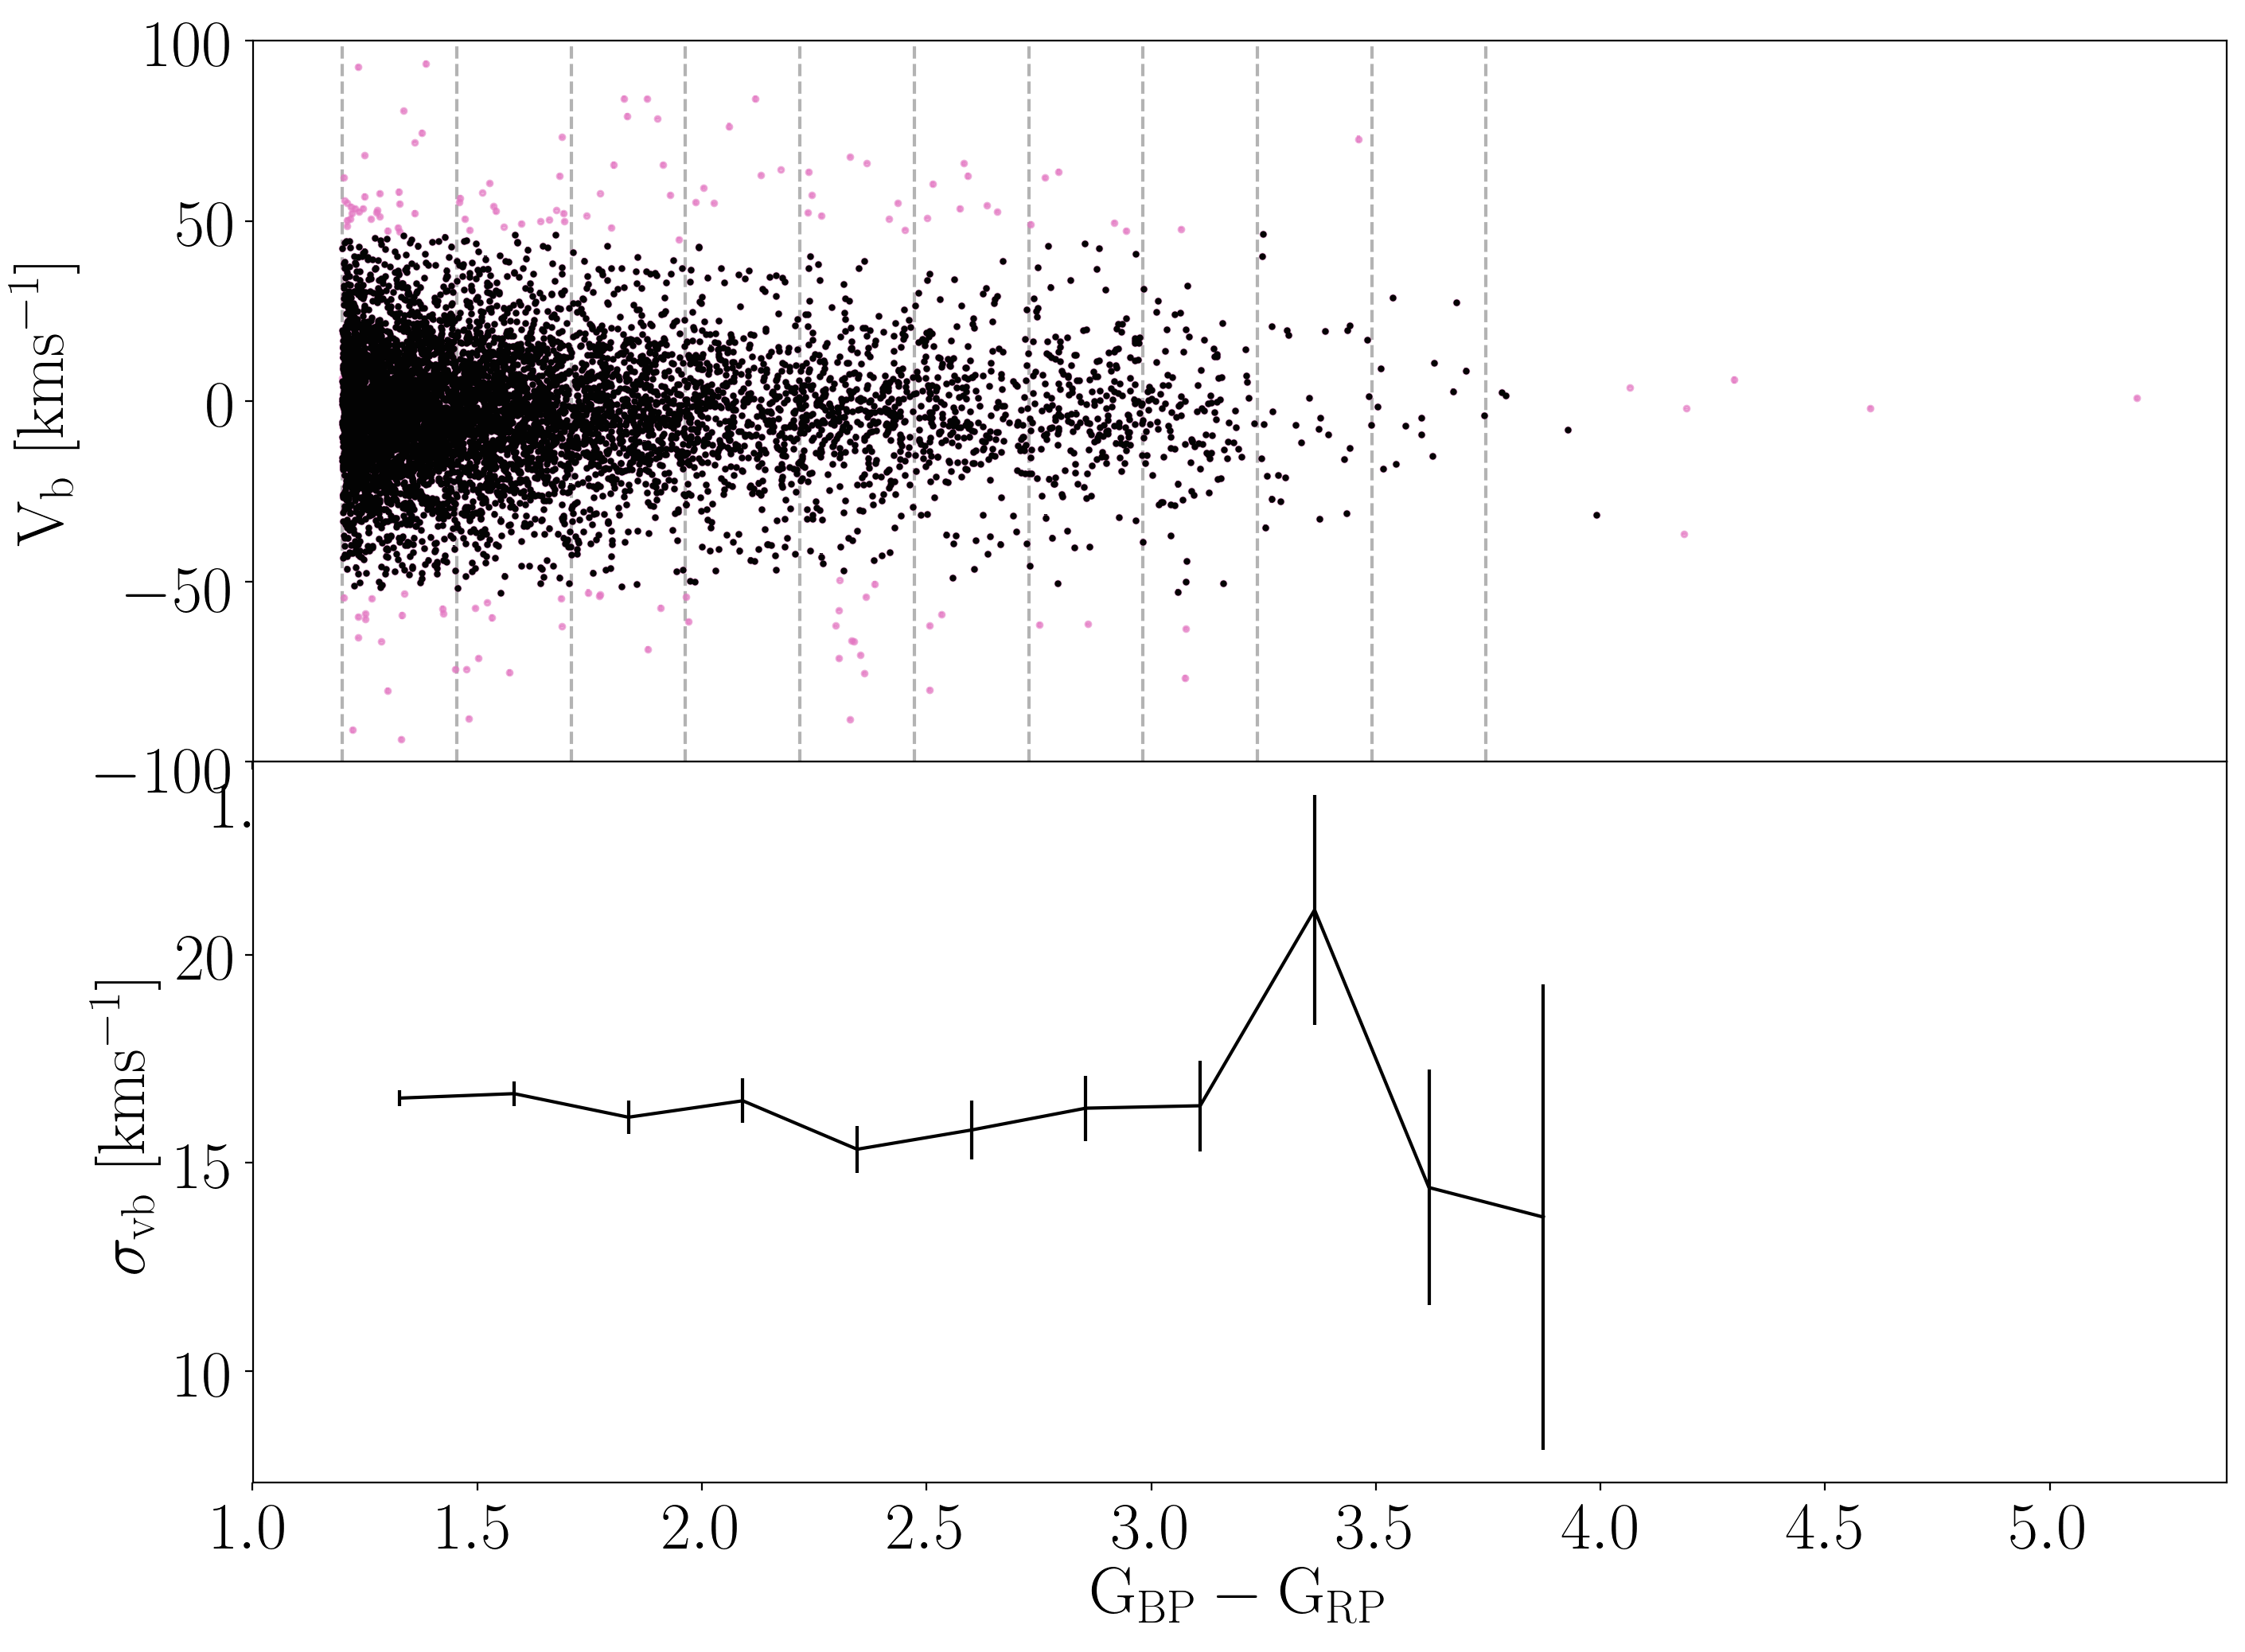

In [96]:
fig = plt.figure(figsize=(16, 12), dpi=200)

v = mdwarfs2.vb.values
# v = np.sqrt(mdwarfs2.v_ra**2 + mdwarfs2.v_dec**2)

# Top panel
ax1 = fig.add_subplot(211)
ax1.errorbar(mdwarfs2.bprp, v, yerr=mdwarfs2.vb_err,
             color="tab:pink", fmt=".", ms=5, rasterized=True, alpha=.6)

greys = [".01", ".01"]
sigma_vb, sigma_vb_err = [], []
for i, m in enumerate(color_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
#     clipping_mask = np.ones(len(clipping_mask), dtype="bool")
#     sigma_vb.append(np.std(mdwarfs2.vb.values[m]))
    sigma_vb.append(np.std(v_clipped))
    sigma_vb_err.append(err_on_sample_std_dev(np.std(v_clipped), float(len(v_clipped))))
    ax1.errorbar(mdwarfs2.bprp[m][clipping_mask], v[m][clipping_mask],
                 yerr=mdwarfs2.vb_err[m][clipping_mask],
                 fmt=".", mec="none", color=greys[i % 2], rasterized=True)
    plt.axvline(color_bins[i], color=".7", ls="--")
ax1.set_ylabel("$\mathrm{V_b~[kms^{-1}]}$")
plt.ylim(-100, 100)
    
# Bottom panel
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.errorbar(mid_color_bin, sigma_vb, yerr=sigma_vb_err, fmt="k")
# plt.ylim(17, 22)
# plt.xlim(1.2, 3.5)
ax2.set_xlabel("$\mathrm{G_{BP}-G_{RP}}$")
ax2.set_ylabel("$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
plt.subplots_adjust(hspace=0)
plt.savefig("paper/vb_vs_color.pdf")

niter =  2 1 stars removed kurtosis =  0.6342340420572632
niter =  4 7 stars removed kurtosis =  0.6904312927004148
niter =  3 10 stars removed kurtosis =  0.3598796261734005
niter =  6 20 stars removed kurtosis =  0.5027720263701578
niter =  2 7 stars removed kurtosis =  0.3753155505417425
niter =  4 13 stars removed kurtosis =  0.3664718801976288
niter =  5 12 stars removed kurtosis =  0.39720550485928463
niter =  3 11 stars removed kurtosis =  0.19296740998610895
niter =  4 13 stars removed kurtosis =  0.343937058011889
niter =  2 10 stars removed kurtosis =  0.32126102889454433
niter =  3 27 stars removed kurtosis =  0.16510794627533
0.0003881198894414189 +- 0.000308106746765826
1.259692926284429


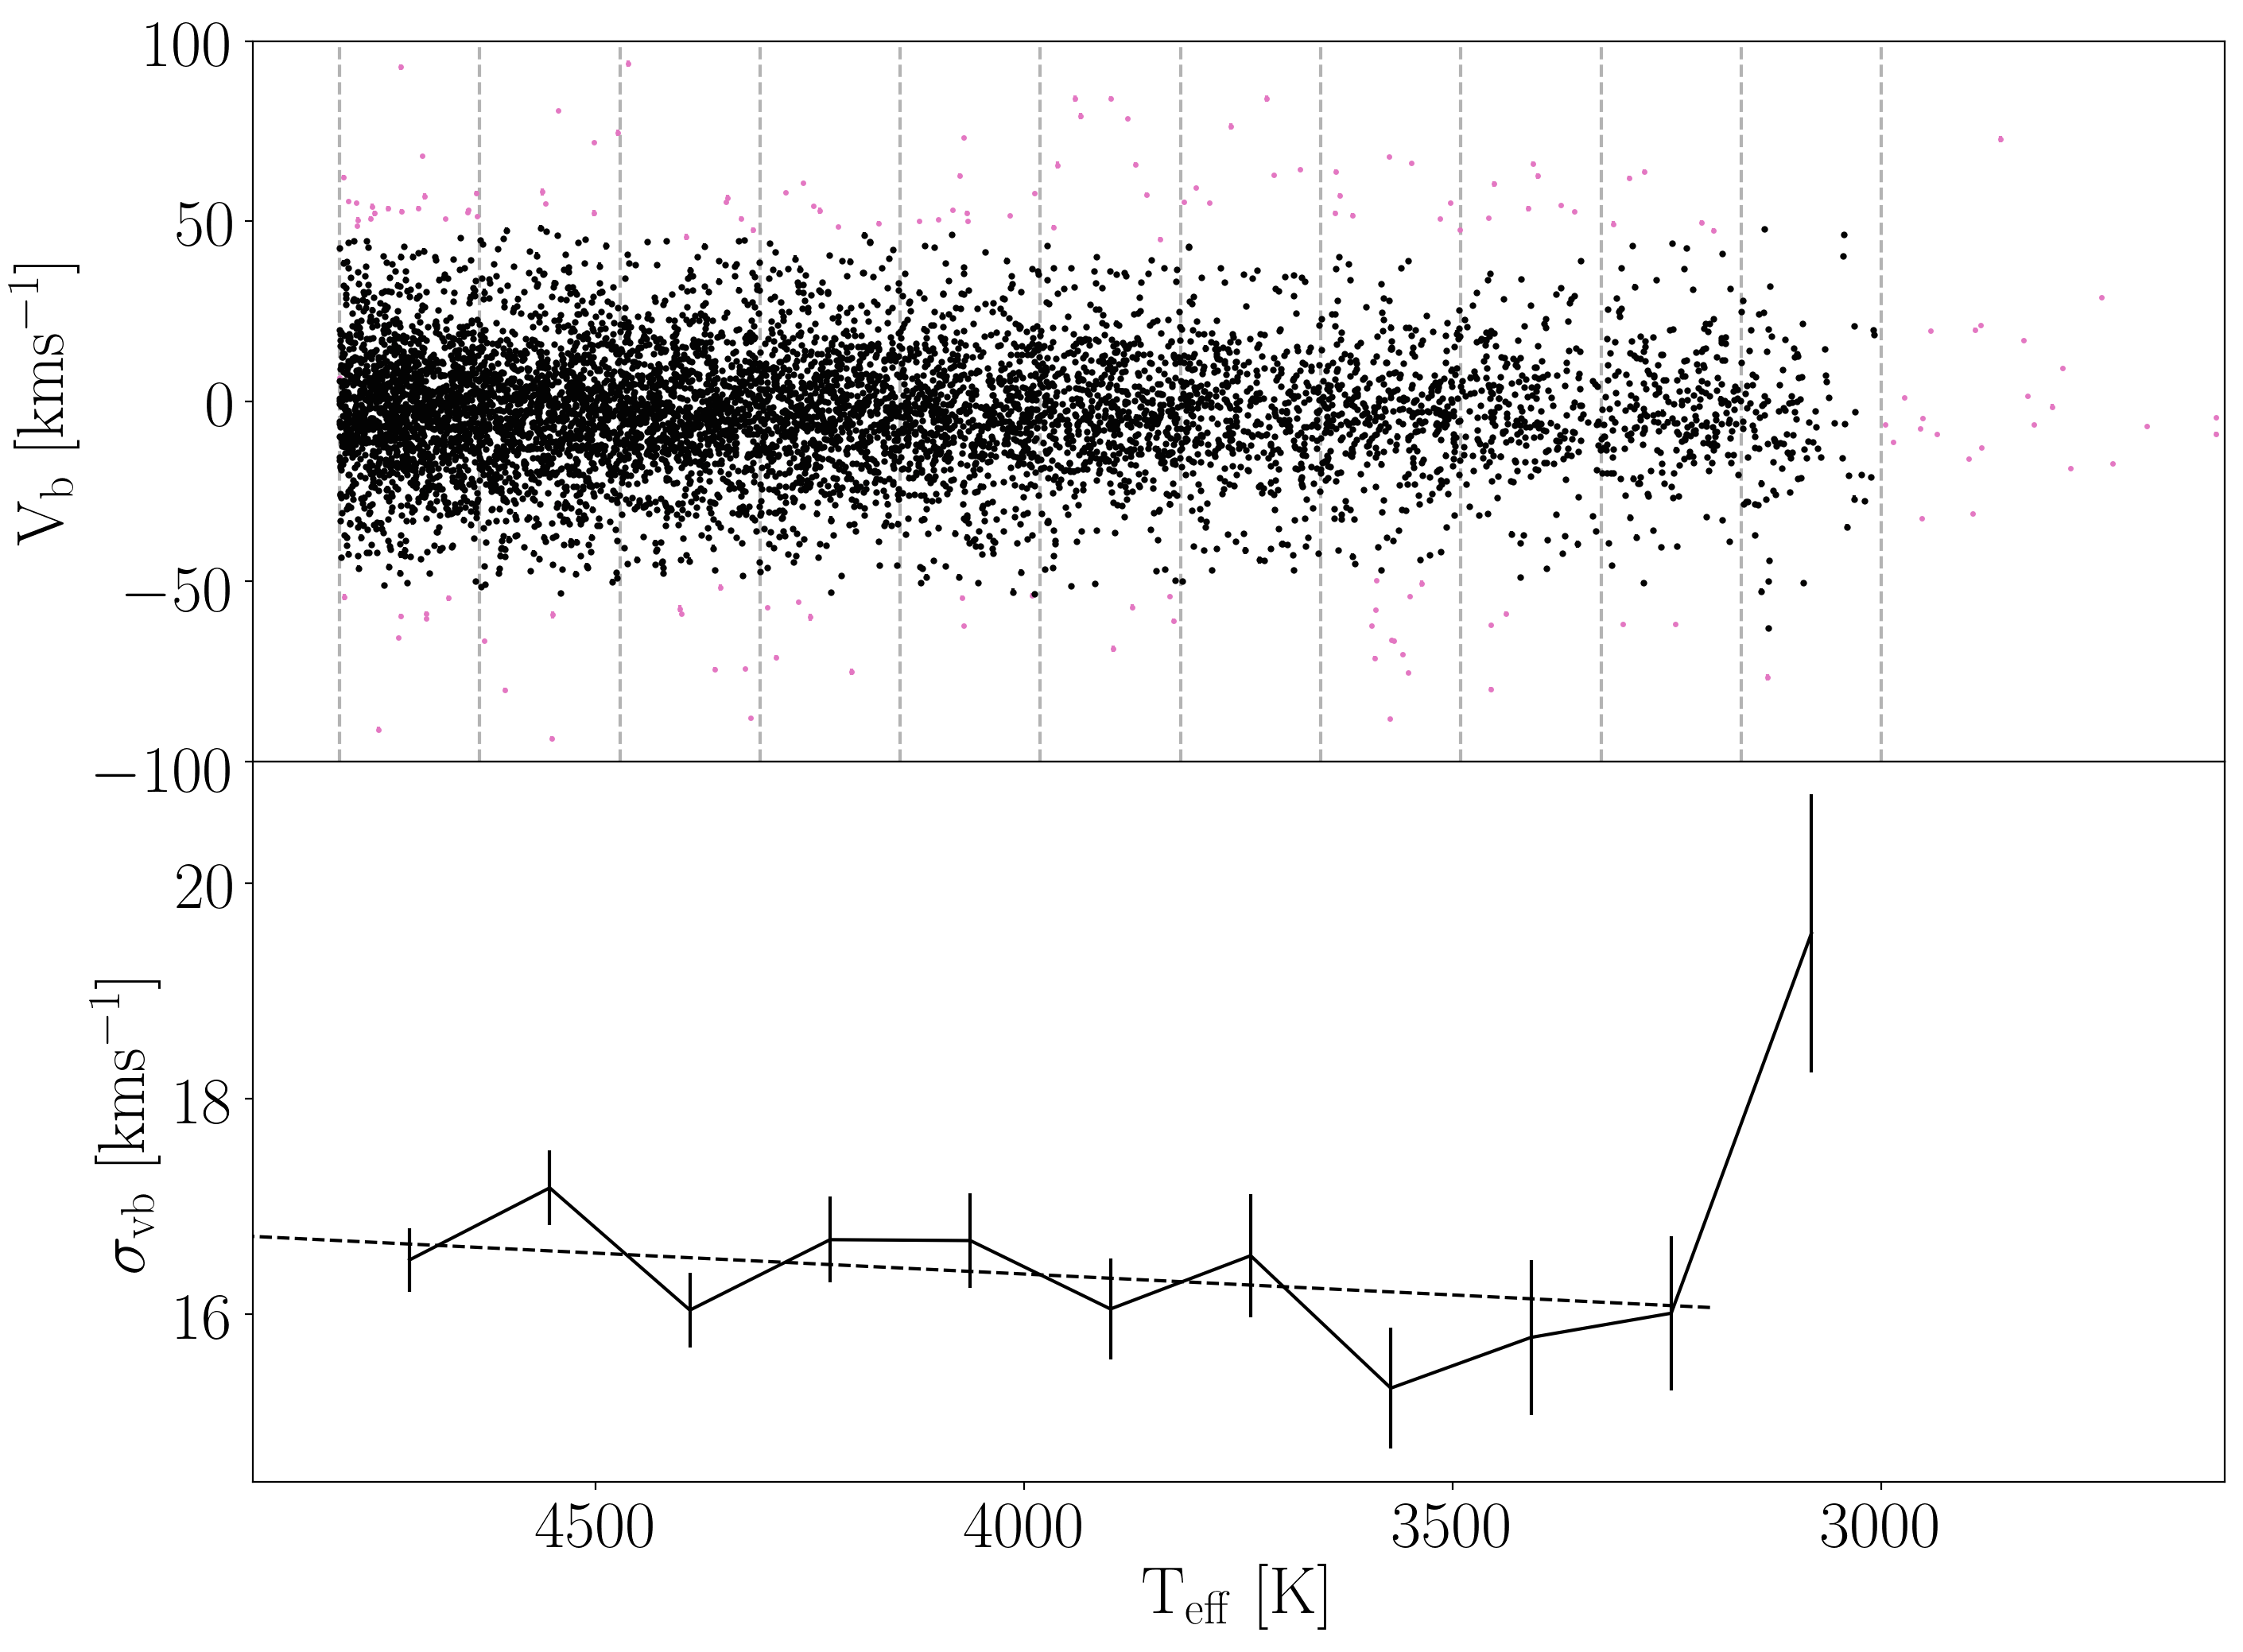

In [116]:
fig = plt.figure(figsize=(16, 12), dpi=200)

v = mdwarfs2.vb.values
# v = np.sqrt(mdwarfs2.v_ra**2 + mdwarfs2.v_dec**2)

# Top panel
ax1 = fig.add_subplot(211)
ax1.errorbar(mdwarfs2.color_teffs, v, yerr=mdwarfs2.vb_err,
             fmt=".", color="tab:pink", mec="none", ms=5, rasterized=True, alpha=.99)
ax1.set_xlim(4900, 2600)

clipped_bs = []
bs = []

sigma_vb, sigma_vb_err = [], []
for i, m in enumerate(teff_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
#     clipping_mask = np.ones(len(v[m]), dtype=np.bool)
#     sigma_vb.append(np.std(v[m]))
    sigma_vb.append(np.std(v_clipped))
    sigma_vb_err.append(err_on_sample_std_dev(np.std(v_clipped), float(len(v_clipped))))
    ax1.errorbar(mdwarfs2.color_teffs[m][clipping_mask], v[m][clipping_mask],
                 yerr=mdwarfs2.vb_err[m][clipping_mask],
                 fmt=".", mec="none", color=greys[i % 2], rasterized=True)
    ax1.axvline(teff_bins[i], color=".7", ls="--")
    
    clipped_bs.append(mdwarfs2.b.values[m][~clipping_mask])
    bs.append(mdwarfs2.b.values[m][clipping_mask])
    
ax1.axvline(teff_bins[-1], color=".7", ls="--")


ax1.set_ylabel("$\mathrm{V_b~[kms^{-1}]}$")
plt.ylim(-100, 100)
    
# Bottom panel
ax2 = fig.add_subplot(212, sharex=ax1)

ax2.errorbar(mid_teff_bin, sigma_vb, yerr=sigma_vb_err, fmt="k")
# ax2.xlim(max(mid_teff_bin)+100, min(mid_teff_bin)-100)

# Fit a line
w, Cw = fit_line(np.array(mid_teff_bin), np.array(sigma_vb), np.array(sigma_vb_err))
xs = np.linspace(3200, 4900, 100)
plt.plot(xs, w[0] + w[1]*xs, "k--")
print(w[1], "+-", np.sqrt(Cw[1, 1]))
assert np.isclose(w[1], 0, atol=np.sqrt(Cw[1, 1])*1.5)
print(w[1]/np.sqrt(Cw[1, 1]))

ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{\sigma_{vb}~[kms^{-1}]}$")
plt.subplots_adjust(hspace=0)
plt.savefig("paper/vb_vs_teff.pdf")

Ks_2sampResult(statistic=0.06551574075496236, pvalue=0.6240429710158287)


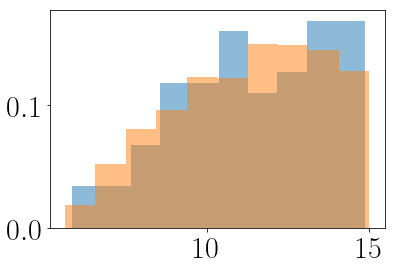

In [111]:
clipped_bs = np.array([i for j in clipped_bs for i in j])
bs = np.array([i for j in bs for i in j])
plt.hist(clipped_bs, normed=True, alpha=.5);
plt.hist(bs, normed=True, alpha=.5)

import scipy.stats as sps
print(sps.ks_2samp(clipped_bs, bs))

So the outliers do not seem to be at preferentially high latitudes.

In [98]:
# gaia_url = "kepler_dr2_1arcsec.fits"

# with fits.open(gaia_url) as data:
#     gaia = pd.DataFrame(data[1].data, dtype="float64")
    
# si = pd.DataFrame(dict({"source_id": gaia.source_id.values}))    

# si.to_csv("kep_gaia_source_ids.csv")

In [99]:
m = np.isfinite(mdwarfs.vz.values)
mdz = mdwarfs.iloc[m]
print(np.shape(mdz))

(537, 120)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


niter =  1 0 stars removed kurtosis =  0.1314936760795602
niter =  1 0 stars removed kurtosis =  -1.2493115379347943
niter =  1 0 stars removed kurtosis =  1.4639799708248322
niter =  4 5 stars removed kurtosis =  0.09744966082338147
niter =  2 1 stars removed kurtosis =  0.5653477117933479
niter =  2 2 stars removed kurtosis =  0.4868422186704926
niter =  2 1 stars removed kurtosis =  0.4332790247820326
0.0010808502022150298 +- 0.0016066459053342612


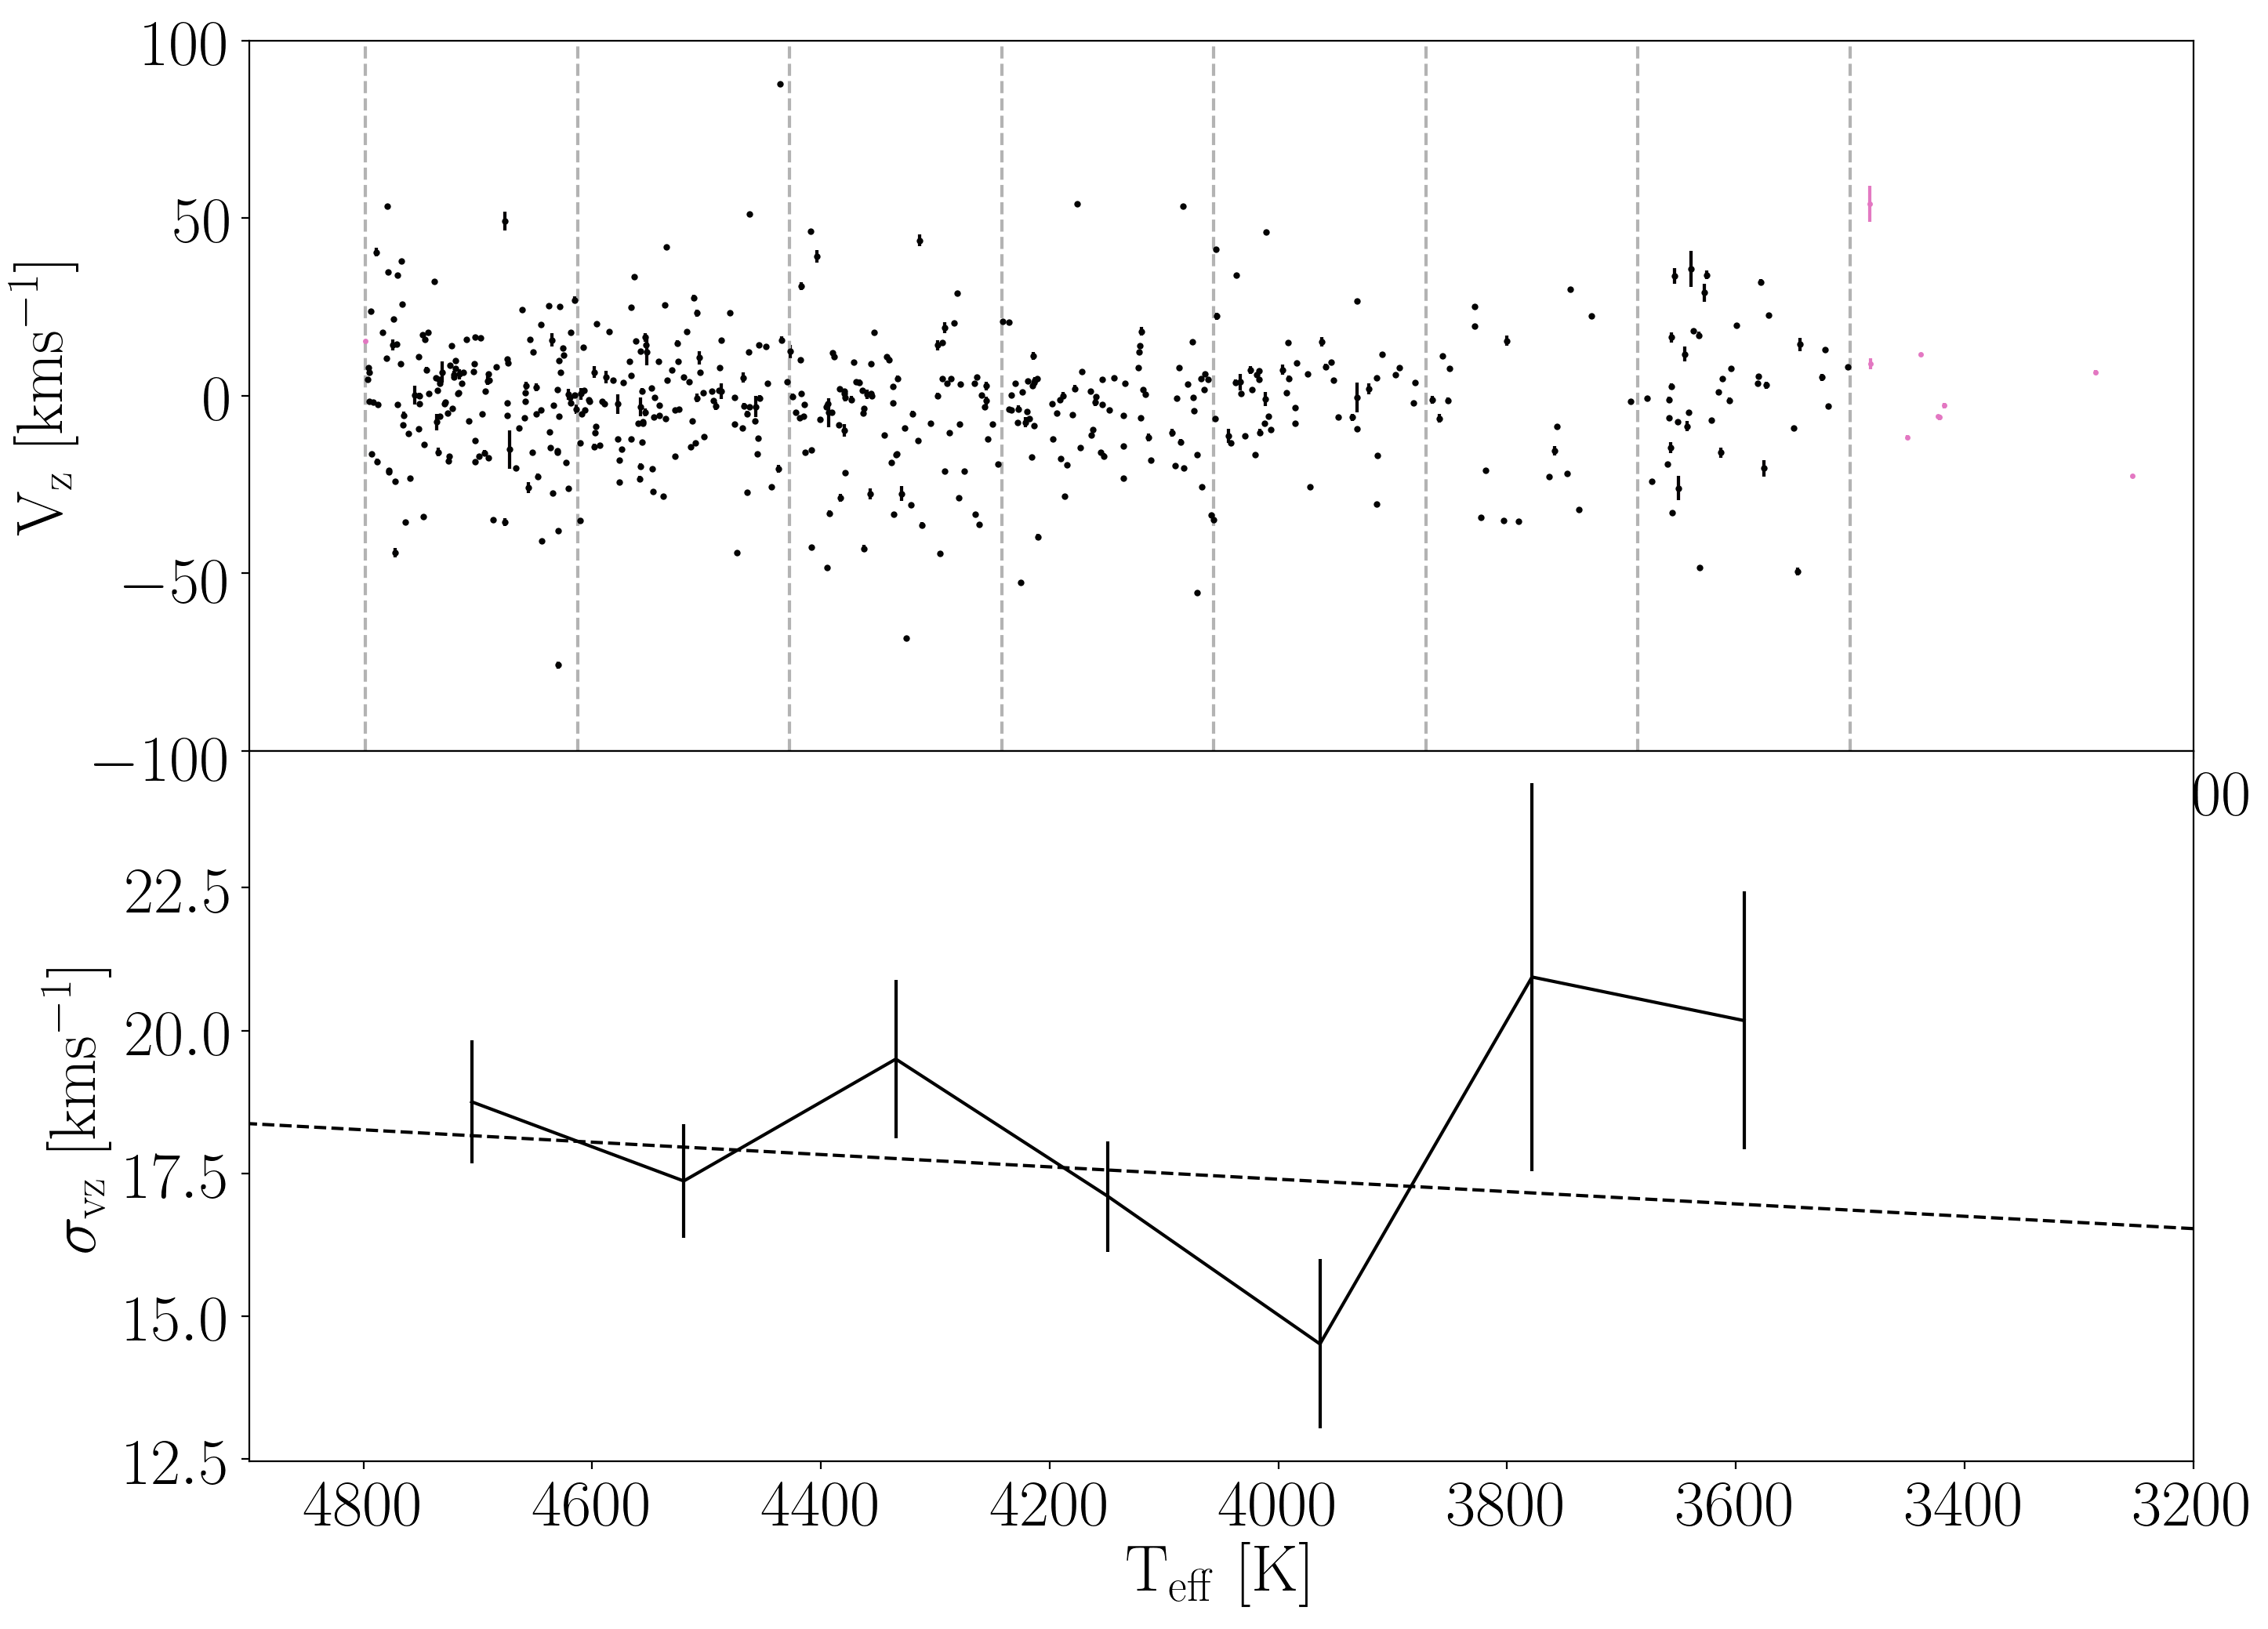

In [117]:
teff_bins_z = np.linspace(3500, max(mdz.color_teffs), 8)
teff_masks_z = select_stars(mdz, teff_bins_z, "color_teffs")
mid_teff_bin_z = np.diff(teff_bins_z)*.5 + teff_bins_z[:-1]

mdz["bprp"] = mdz.bp_dered.values - mdz.rp_dered.values
color_bins_z = np.linspace(min(mdwarfs.bprp.values), 4, 12)
mid_color_bin_z = np.diff(color_bins_z)*.5 + color_bins_z[:-1]
color_masks_z = select_stars(mdwarfs, color_bins_z, "bprp")


fig = plt.figure(figsize=(16, 12), dpi=200)

v = mdz.vz.values
verr = mdz.vz_err.values
teff = mdz.color_teffs.values

# Top panel
ax1 = fig.add_subplot(211)
ax1.errorbar(teff, v, verr, fmt=".", color="tab:pink", mec="none", ms=5, rasterized=True, alpha=.99)
ax1.set_xlim(4900, 3200)

sigma_vz, sigma_vz_err = [], []
for i, m in enumerate(teff_masks_z):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    clipping_mask = np.ones(len(v[m]), dtype=np.bool)
    sigma_vz.append(np.std(v[m]))
#     sigma_vz.append(np.std(v_clipped))
    sigma_vz_err.append(err_on_sample_std_dev(np.std(v_clipped), float(len(v_clipped))))
    
    ax1.errorbar(teff[m][clipping_mask], v[m][clipping_mask], yerr=verr[m][clipping_mask],
                 fmt=".", mec="none", color=greys[i % 2], rasterized=True)
    ax1.axvline(teff_bins_z[i], color=".7", ls="--")
ax1.axvline(teff_bins_z[-1], color=".7", ls="--")
    
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
plt.ylim(-100, 100)
    
# Bottom panel
ax2 = fig.add_subplot(212, sharex=ax1)

ax2.errorbar(mid_teff_bin_z, sigma_vz, yerr=sigma_vz_err, fmt="k")

# Fit a line
w, Cw = fit_line(np.array(mid_teff_bin_z), np.array(sigma_vz), np.array(sigma_vz_err))
xs = np.linspace(3200, 4900, 100)
plt.plot(xs, w[0] + w[1]*xs, "k--")
print(w[1], "+-", np.sqrt(Cw[1, 1]))
assert np.isclose(w[1], 0, atol=np.sqrt(Cw[1, 1]))

ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\mathrm{\sigma_{vz}~[kms^{-1}]}$")
plt.subplots_adjust(hspace=0)